In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
pd.set_option('display.max_columns', None)
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Importing the data
final_df=pd.DataFrame()
a_df=pd.DataFrame()
b_df=pd.DataFrame()
c_df=pd.DataFrame()

for file_n in os.listdir('listings'):
    if file_n[0]=='.':
        continue
    else:
        add_df = pd.read_csv(f'listings/{file_n}')
        if len(add_df.columns)==106:
            final_df = pd.concat([final_df, add_df], axis=0)
        elif len(add_df.columns)==96:
            a_df = pd.concat([a_df, add_df], axis=0)
        elif len(add_df.columns)==95:
            b_df = pd.concat([b_df, add_df], axis=0)
        else:
            c_df = pd.concat([c_df, add_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [3]:
#These are the columns not present in 2018 reports. They will be dropped.
not_in_2018 = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
       'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'number_of_reviews_ltm', 
       'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
       'calculated_host_listings_count_shared_rooms']
sf_df = final_df.drop(columns=not_in_2018)
sf_df = pd.concat([sf_df, a_df], axis=0)

#drop one column not in 2017
sf_df = sf_df.drop(columns=['is_business_travel_ready'])
sf_df = pd.concat([sf_df, b_df], axis=0)

#drop 3 columns not in 2016 & Prior
sf_df = sf_df.drop(columns=['access', 'interaction', 'house_rules'])
sf_df = pd.concat([sf_df, c_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [4]:
#Converting Existing Data Columns to Dates
sf_df['last_scraped'] = pd.to_datetime(sf_df['last_scraped'])
sf_df['host_since'] = pd.to_datetime(sf_df['host_since'])
#Adding new date features
sf_df['year'] = sf_df['last_scraped'].transform(lambda x: x.year)
sf_df['month-year'] = sf_df['last_scraped'].transform(lambda x: f'{x.month} {x.year}')
sf_df['month'] = sf_df['last_scraped'].transform(lambda x: x.month)
sf_df['day_of_week'] = sf_df['last_scraped'].transform(lambda x: x.dt.dayofweek)
sf_df['day'] = sf_df['last_scraped'].transform(lambda x: x.day)

#Converting All Price Related Columns from Objects to Floats
sf_df['price'] = sf_df['price'].transform(lambda x: float(x.replace(',', '').replace('$', '')))
sf_df['extra_people'] = sf_df['extra_people'].transform(lambda x: float(x.replace(',', '').replace('$', '')))

#Fill NaNs in fee columns with 0's, because no additional fee, then convert
sf_df[['security_deposit','cleaning_fee']] = sf_df[['security_deposit','cleaning_fee']].fillna(int(0))
sf_df['security_deposit'] = sf_df['security_deposit'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))
sf_df['cleaning_fee'] = sf_df['cleaning_fee'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))

#Dropping columns that have over 75% null
over_70_null = sf_df.columns[sf_df.isnull().sum()/len(sf_df) > 0.70]
sf_df = sf_df.drop(columns=over_70_null)

#Removing Outliers (0 & over 2000 daily rate)
outlier_thresh=2000
sf_df = sf_df.loc[~((sf_df['price'] == 0) | (sf_df['price'] > outlier_thresh))]

#Filling the NaNs in beds, bathrooms, bedrooms
#Assume that if the tenant has the full apartment, they have a bathroom/bedroom
cond1= (sf_df['room_type']=='Entire home/apt')
sf_df.loc[cond1 & (sf_df['beds']==0), sf_df.columns=='beds'] = 1
sf_df.loc[cond1 & (sf_df['bathrooms']==0), sf_df.columns=='bathrooms'] = 1
#For the rest, just fill na
sf_df[['beds','bathrooms', 'bedrooms']] = sf_df[['beds','bathrooms', 'bedrooms']].fillna(0)

#For review scores, let's just fillin with the average
review_lst = ['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']
for review in review_lst:
    sf_df[review] = sf_df[review].fillna(sf_df[review].mean())

In [10]:
train_df2, test = train_test_split(sf_df, test_size = 0.3)

In [11]:
#Adding in all feature engineering for best performing model with Random Forest
train_df2['amenities'] = train_df2['amenities'].fillna('0')
train_df2['num_amenities'] = train_df2['amenities'].transform(lambda x: len(x.split(',')))
train_df2[['space','summary','description','name']] = train_df2[['space','summary','description','name']].fillna('0')
train_df2['len_space'] = train_df2['space'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_summary'] = train_df2['summary'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_description'] = train_df2['description'].transform(lambda x: '0' if x==0 else len(x))
train_df2['len_name'] = train_df2['name'].transform(lambda x: 0 if x=='0' else len(x))

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [78]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed','property_type',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'room_type', 'security_deposit', 'month', 
          'year', 'summary']
X8 = train_df2[features]
y8 = train_df2['price'].apply(np.log)
X8 = pd.get_dummies(X8, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])
X_train, X_val, y_train, y_val = train_test_split(X8, y8, test_size=0.3)

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_features = 100, strip_accents = 'unicode', stop_words='english')

In [80]:
text_col = 'summary'
word_vector_sum = vectorizer.fit(X_train[text_col])
word_matrix_sum = vectorizer.transform(X_train[text_col]).toarray()
features_sum = word_vector_sum.get_feature_names()

In [81]:
word_vect_df_sum = pd.DataFrame(word_matrix_sum, columns=features_sum)
word_vect_df_sum

,access,apartment,area,available,away,bars,bart,bath,bathroom,bay,beach,beautiful,bed,bedroom,bedrooms,best,block,blocks,building,bus,business,castro,center,city,clean,close,coffee,comfortable,cozy,deck,dining,distance,district,downtown,easy,enjoy,flat,floor,francisco,free,fully,garden,gate,golden,great,guests,heart,hill,home,hotel,house,just,kitchen,large,light,living,ll,located,location,love,min,minutes,mission,modern,muni,near,neighborhood,new,park,parking,perfect,place,private,public,queen,quiet,remodeled,restaurants,room,san,sf,shared,shops,space,spacious,square,stay,street,studio,sunny,transportation,travelers,tv,union,unit,valley,victorian,views,walk,walking
0,0.265096,0.000000,0.0,0.0,0.270211,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.272509,0.00000,0.000000,0.0,0.0,0.000000,0.244993,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.275764,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.345936,0.0,0.00000,0.449186,0.0,0.000000,0.290988,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.251831,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.318765,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.274294,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.320619,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.355368,0.00000,0.000000,0.0,0.0,0.000000,0.319486,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.292883,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.281138,0.000000,0.0,0.000000,0.000000,0.000000,0.257514,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.370091,0.000000,0.000000,0.415690,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.357697,0.0,0.000000
2,0.000000,0.232342,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.269530,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.288544,0.000000,0.0,0.0,0.0,0.0,0.0,0.247213,0.000000,0.0,0.00000,0.000000,0.0,0.275498,0.287808,0.00000,0.0,0.0,0.000000,0.000000,0.215314,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.243639,0.000000,0.224179,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.261222,0.000000,0.000000,0.000000,0.000000,0.249078,0.0,0.000000,0.000000,0.000000,0.290736,0.000000,0.000000,0.325029,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.306336,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.315027,0.000000,0.0,0.000000,0.0,0.0,0.0,0.275801,0.32966,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.255483,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.206955,0.0,0.0,0.0,0.0,0.0,0.252964,0.000000,0.0,0.30992,0.000000,0.0,0.000000,0.294504,0.00000,0.0,0.0,0.000000,0.000000,0.220323,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.278605,0.0,0.000000,0.000000,0.217102,0.000000,0.205073,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.237100,0.000000,0.000000,0.299286,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.384780,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.321159,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.486888,0.000000,0.000000,0.0,0.0,0.524488,0.000000,0.000000,0.0,0.00000,0.00000

In [82]:
X_train2 = X_train.copy()
for col in word_vect_df_sum.columns:
    X_train2[col]=word_vect_df_sum[col]

In [83]:
X_train2 = X_train2.drop(columns='summary')

In [84]:
print(X_train.shape, word_vect_df_sum.shape, X_train2.shape, y_train.shape)

(192805, 122) (192805, 100) (192805, 220) (192805,)


In [85]:
estimator = RandomForestRegressor()
model8 = estimator.fit(X_train2,y_train)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [87]:
word_matrix_sum_val = vectorizer.transform(X_val[text_col]).toarray()
features_sum_val = word_vector_sum.get_feature_names()
word_vect_df_sum_val = pd.DataFrame(word_matrix_sum_val, columns=features_sum_val)
X_val2 = X_val.copy()
for col in word_vect_df_sum_val.columns:
    X_val2[col]=word_vect_df_sum_val[col]
X_val2 = X_val2.drop(columns=['summary'])

In [89]:
preds = model8.predict(X_val2)
r2 = model8.score(X_val2, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train2, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X_val2, y_val, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

R2: 0.9027012103051673, RMSE: 1.2409437211661578,
Train Cross Val Score: 0.8637079634387909, Validation Cross Val Score: 0.7628766631298888


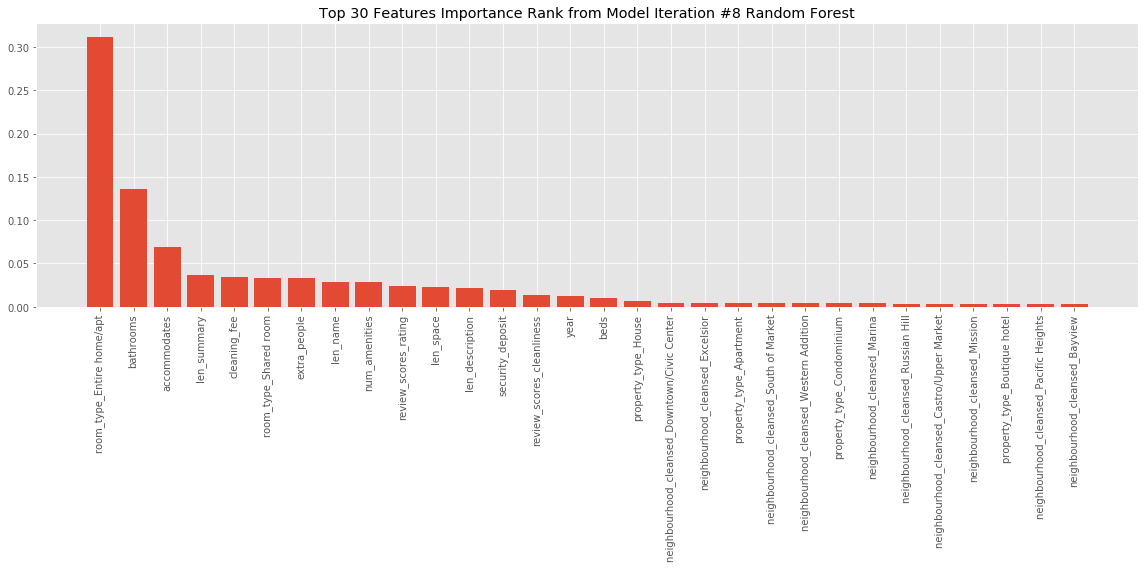

In [91]:
rf_features = X_train2.columns
rf_feature_imp = model8.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #8 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Length_text_feat_imp.png', dpi=300)
plt.show()